In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

In [2]:
FRED_MD = pd.read_csv("C:\MSc_Project\FRED_MD\current.csv")

In [3]:
FRED_MD.drop(0, axis=0, inplace=True)
index = pd.date_range('1959-01-01', periods=len(FRED_MD), freq='M')
FRED_MD.set_index(index, inplace=True)

In [4]:
ip = FRED_MD['INDPRO']

In [5]:
# remove the last NA row
ip = ip.dropna()

<AxesSubplot:>

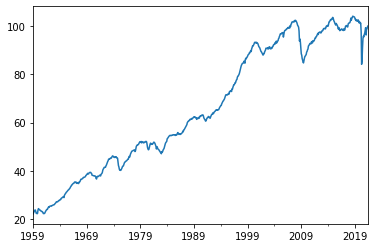

In [6]:
ip.plot()

In [7]:
# the above plot clearly suggests some sort of time trend and thus the 
# IP series is non stationary

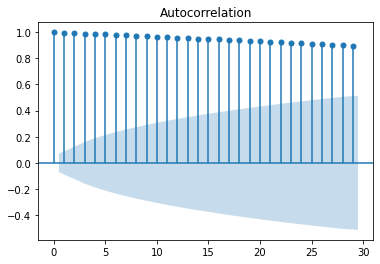

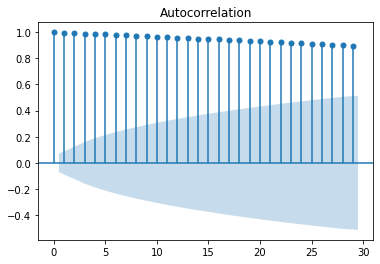

In [8]:
plot_acf(ip)

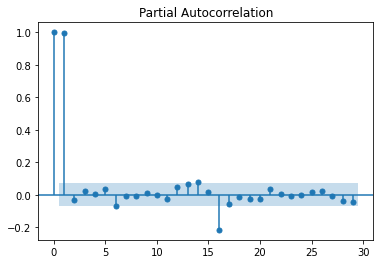

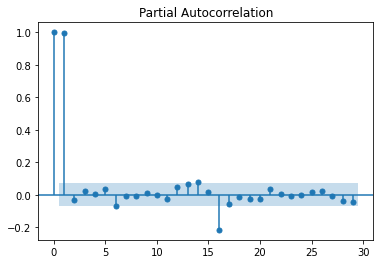

In [9]:
plot_pacf(ip)

# log differences

In [10]:
ip_ln = np.log(ip)

<AxesSubplot:>

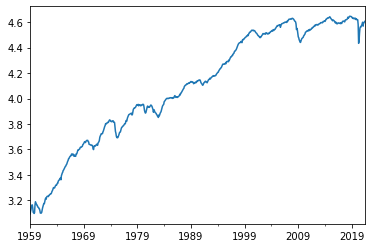

In [11]:
ip_ln.plot()

# stationarity check

In [12]:
ip_ln_adf = adfuller(ip_ln)

In [13]:
ip_ln_adf

(-2.115134809621311,
 0.23847252820320203,
 11,
 738,
 {'1%': -3.4392418578608983,
  '5%': -2.86546426916434,
  '10%': -2.568859710342903},
 -4740.231061712144)

In [14]:
print('The p-value from the augmented dickey fuller test on the IP time series is', str(ip_ln_adf[1]))
print('As this is greater than 0.05, we fail to reject the null hypothesis that the time series can be represented by a unit root and thus the data is non stationary')

The p-value from the augmented dickey fuller test on the IP time series is 0.23847252820320203
As this is greater than 0.05, we fail to reject the null hypothesis that the time series can be represented by a unit root and thus the data is non stationary


furthermore, a high number of lags in the autocorrelation suggests a strong correlation between time periods with some differencing required.


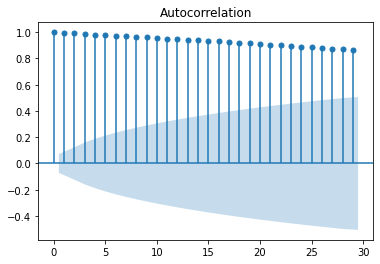

In [15]:
plot_acf(ip_ln)
print('furthermore, a high number of lags in the autocorrelation suggests a strong correlation between time periods with some differencing required.')

But, the PACF suggests that only the first lag carries significant correlation as the subsequent lags in the ACF chart can all be explained by the first one.


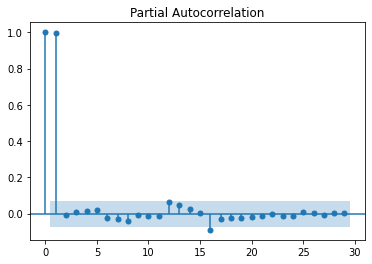

In [16]:
plot_pacf(ip_ln)
print('But, the PACF suggests that only the first lag carries significant correlation as the subsequent lags in the ACF chart can all be explained by the first one.')

# Taking first differences

In [17]:
ip_ln_1st_diff = ip_ln.diff()

In [18]:
ip_ln_1st_diff

1959-01-31         NaN
1959-02-28    0.019395
1959-03-31    0.014303
1959-04-30    0.021077
1959-05-31    0.014950
                ...   
2021-02-28   -0.031013
2021-03-31    0.026298
2021-04-30    0.000263
2021-05-31    0.006924
2021-06-30    0.004421
Freq: M, Name: INDPRO, Length: 750, dtype: float64

In [19]:
# remove the NaN from differencing
ip_ln_1st_diff = ip_ln_1st_diff.dropna()

<AxesSubplot:>

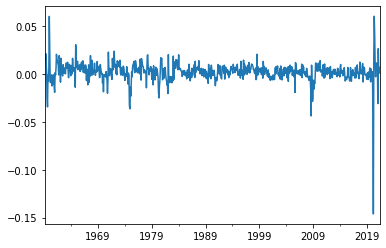

In [20]:
ip_ln_1st_diff.plot()

In [21]:
ip_ln_1st_diff_adf = adfuller(ip_ln_1st_diff)

In [22]:
ip_ln_1st_diff_adf

(-7.192924073878421,
 2.476686536351122e-10,
 10,
 738,
 {'1%': -3.4392418578608983,
  '5%': -2.86546426916434,
  '10%': -2.568859710342903},
 -4727.716318473373)

In [23]:
print('The p-value from the augmented dickey fuller teset on the IP time series is', str(ip_ln_1st_diff_adf[1]))
print('As this is less than 0.01, we reject the null hypothesis that the time series can be represented by a unit root and thus the data is stationary at the 1% significance level.')

The p-value from the augmented dickey fuller teset on the IP time series is 2.476686536351122e-10
As this is less than 0.01, we reject the null hypothesis that the time series can be represented by a unit root and thus the data is stationary at the 1% significance level.


In [24]:
ip_ln_1st_diff_adf[1] < 0.01

True

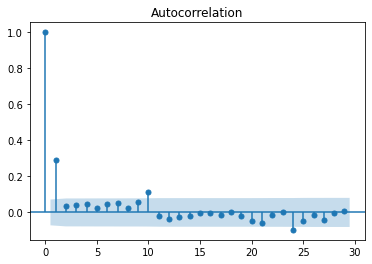

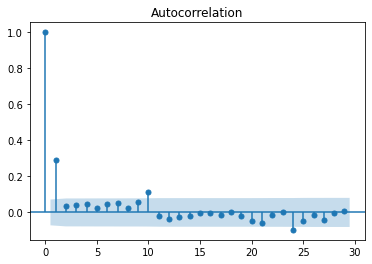

In [25]:
plot_acf(ip_ln_1st_diff)

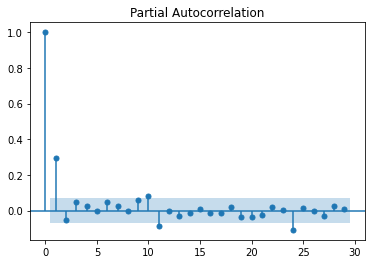

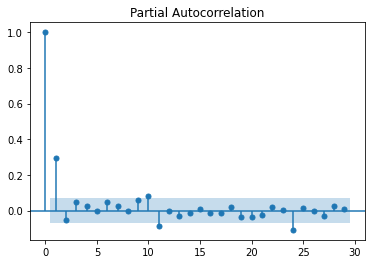

In [26]:
plot_pacf(ip_ln_1st_diff)

In [27]:
print('Therefore, we are happy with a single difference in ln(IP) to make it stationary')

Therefore, we are happy with a single difference in ln(IP) to make it stationary


# Fitting the benchmark AR(1) model of IP

In [28]:
# training periods made to match the nowcast ML models
ip_train = ip_ln_1st_diff[:'2017-01']
ip_test = ip_ln_1st_diff['2017-01':]

In [29]:
model = AutoReg(ip_train, lags = 1)

c:\users\pecol\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [30]:
ip_fit = model.fit()

In [31]:
print(ip_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                 INDPRO   No. Observations:                  696
Model:                     AutoReg(1)   Log Likelihood                2413.562
Method:               Conditional MLE   S.D. of innovations              0.008
Date:                Wed, 29 Sep 2021   AIC                             -9.775
Time:                        17:27:40   BIC                             -9.755
Sample:                    03-31-1959   HQIC                            -9.767
                         - 01-31-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0013      0.000      4.533      0.000       0.001       0.002
INDPRO.L1      0.3668      0.035     10.432      0.000       0.298       0.436
                                    Roots           

<AxesSubplot:>

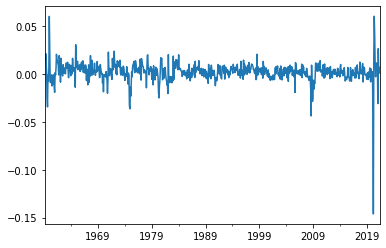

In [32]:
ip_ln_1st_diff.plot()

In [33]:
history = [x for x in ip_train]

In [34]:
# perform rolling one period ahead forecasts
forecasts = []
history = [x for x in ip_train]
for j in range(len(ip_test)):
    model = AutoReg(history, lags = 1, old_names = True)
    results = model.fit()
    output = results.forecast()
    yhat = output[0]
    # append the latest forecast to yhat for future evaluation
    forecasts.append(yhat)
    obs = ip_test[j]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
mse = ((forecasts - ip_test) ** 2).mean()

predicted=0.000775, expected=-0.001530
predicted=0.000771, expected=-0.003825
predicted=-0.000080, expected=0.007484
predicted=0.004080, expected=0.009338
predicted=0.004771, expected=0.001106
predicted=0.001746, expected=0.001568
predicted=0.001915, expected=-0.000948
predicted=0.000989, expected=-0.005039
predicted=-0.000522, expected=0.000431
predicted=0.001486, expected=0.012350
predicted=0.005868, expected=0.002818
predicted=0.002372, expected=0.000953
predicted=0.001688, expected=-0.000133
predicted=0.001288, expected=0.002891
predicted=0.002396, expected=0.006360
predicted=0.003670, expected=0.010807
predicted=0.005312, expected=-0.008436
predicted=-0.001729, expected=0.007420
predicted=0.004040, expected=0.002349
predicted=0.002204, expected=0.005955
predicted=0.003513, expected=-0.000330
predicted=0.001236, expected=-0.001385
predicted=0.000851, expected=-0.000719
predicted=0.001089, expected=-0.000440
predicted=0.001188, expected=-0.005452
predicted=-0.000636, expected=-0.005

In [35]:
print("MSE of AR(1) differenced IP model is", mse)

MSE of AR(1) differenced IP model is 0.0006376148488192406


In [36]:
len(forecasts)

54

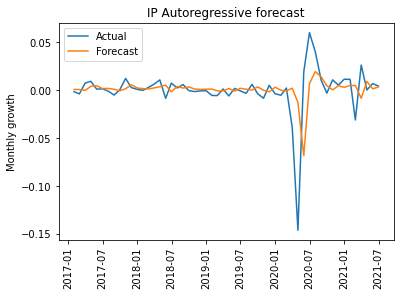

In [37]:
plt.title('IP Autoregressive forecast')
plt.ylabel('Monthly growth',loc = 'center')
plt.plot(ip_test)
plt.plot(pd.DataFrame(forecasts, index = ip_test.index))
plt.legend(['Actual', 'Forecast'])
plt.xticks(rotation = 90)
plt.show()

# convert back to levels

In [38]:
ip_hist = ip['2016-12':]

In [39]:
# calculating levels based on previous period
forecast_levels = []
for i in range(len(forecasts)):
    forecast_levels.append(ip_hist[i] * (1+(forecasts[i])))

In [40]:
mean_squared_error(ip[ip_test.index], forecast_levels)

5.204229327264404

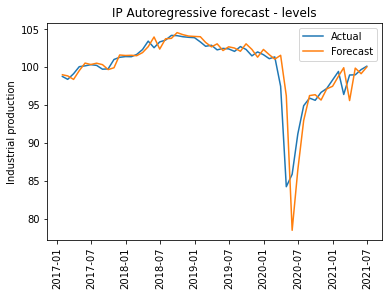

In [41]:
plt.title('IP Autoregressive forecast - levels')
plt.ylabel('Industrial production',loc = 'center')
plt.plot(ip[ip_test.index])
plt.plot(ip[ip_test.index].index, forecast_levels)
plt.legend(['Actual', 'Forecast'])
plt.xticks(rotation = 90)
plt.show()

In [42]:
rmse = mean_squared_error(ip[ip_test.index], forecast_levels, squared=False)

In [43]:
rmse

2.2812780030641604

In [49]:
ip['2020-01':]

2020-01-31    101.0918
2020-02-29    101.3247
2020-03-31     97.4477
2020-04-30     84.2018
2020-05-31     85.8434
2020-06-30     91.1622
2020-07-31     94.8887
2020-08-31     95.8924
2020-09-30     95.6019
2020-10-31     96.6454
2020-11-30     97.1609
2020-12-31     98.2854
2021-01-31     99.4076
2021-02-28     96.3720
2021-03-31     98.9400
2021-04-30     98.9660
2021-05-31     99.6536
2021-06-30    100.0951
Freq: M, Name: INDPRO, dtype: float64

In [45]:
len(forecast_levels[:len(ip['2017-01':'2019-12'])])

36

In [46]:
mse_pre_covid = mean_squared_error(ip['2017-01':'2019-12'], forecast_levels[:len(ip['2017-01':'2019-12'])])

In [47]:
mse_pre_covid

0.3190729201590323